In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from datetime import date, datetime, timedelta
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

In [2]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

plt.rc('font', family='NanumBarunGothic')

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 27 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

In [3]:
# 액티브는 sheet 3개 (기업개요_외감 / 기업개요 / 휴폐업이력) 
active_ex = pd.read_excel('/content/drive/MyDrive/Numble_Challenge/data/액티브 중소법인 재무보유.xlsx', sheet_name = 0)
active_normal = pd.read_excel('/content/drive/MyDrive/Numble_Challenge/data/액티브 중소법인 재무보유.xlsx', sheet_name = 1)
active_history = pd.read_excel('/content/drive/MyDrive/Numble_Challenge/data/액티브 중소법인 재무보유.xlsx', sheet_name = 2)

# 휴페업은 sheet 2개 (기업개요 / 휴폐업이력)
close_normal = pd.read_excel('/content/drive/MyDrive/Numble_Challenge/data/휴폐업 중소법인 재무보유.xlsx',sheet_name = 0)
close_history = pd.read_excel('/content/drive/MyDrive/Numble_Challenge/data/휴폐업 중소법인 재무보유.xlsx',sheet_name = 1)

finance = pd.read_table('/content/drive/MyDrive/Numble_Challenge/data/재무데이터.txt', encoding = 'CP949')

layout = pd.read_excel('/content/drive/MyDrive/Numble_Challenge/data/넘블 챌린지 개방데이터 레이아웃.xlsx')

In [4]:
# 컬럼 한글로 변경
eng = layout['영문칼럼명'].tolist()
kor = layout['한글칼럼명'].tolist()

active_ex.rename(columns={'CMP_NM1':'CMP_NM'}, inplace=True)
del active_normal['CMP_NM1']

# 컬럼명이 일치하는 인덱스 확인
name_ex = active_ex.columns.tolist()
name_normal = active_normal.columns.tolist()

active_ex_list = []
active_normal_list = []
for i in name_ex:
  try:
    active_ex_list.append(eng.index(i))
  except:
    pass

for i in name_normal:
  try:
    active_normal_list.append(eng.index(i))
  except:
    pass

# 한글로 컬럼명 변경
for i in active_ex_list:
  active_ex = active_ex.rename(columns={eng[i] : kor[i]})

# 한글로 컬럼명 변경
for i in active_normal_list:
  active_normal = active_normal.rename(columns={eng[i] : kor[i]})

---
# 1. 데스벨리구간 분포 확인
---
- 기업마다 휴업되는 시기가 다르니까 → **어떤 특정 시기**에 많이되더라 도 있지 않을까?  
(1~2단계에 폐업을 많이하고, 3단계, 5단계에서 휴업을 하더라)

→ 사업자등록하고 ~ 1회 휴업완료 ⇒  데스밸리구간을 찾고자함 

---
### 1-1 엑티브 액셀 파일 
---

In [5]:
active_history = pd.read_excel('/content/drive/MyDrive/Numble_Challenge/data/액티브 중소법인 재무보유.xlsx', sheet_name = 2)

In [6]:
# 99991231 데이터 20221027로 변경
for i in range(len(active_history)):
  if active_history['END_DATE'][i] == 99991231:
    active_history['END_DATE'][i] = 20221027

# STAR_OCR_DATE 데이터를 STRT_DATE에 덮에 씌우기
for i in range(len(active_history)):
  if np.isnan(active_history['STAT_OCR_DATE'][i]) == False:
    active_history['STRT_DATE'][i] = active_history['STAT_OCR_DATE'][i]

# 20200731 데이터 수정하기 
#  조건1, STRT_DATE의 값이 END_DATE보다 크다면 None
#  조건2, STRT_DATE의 값이 END_DATE보다 작다면 20200731
for i in range(len(active_history)):
  if active_history['STRT_DATE'][i] == 20200731:
    if active_history['END_DATE'][i] < active_history['STRT_DATE'][i]:
      active_history['STRT_DATE'][i] = None    
    else :
      pass 


In [7]:
active_history['END_DATE'] = active_history['END_DATE'].astype('str')
active_history['STRT_DATE'] = active_history['STRT_DATE'].fillna(0).astype('int64').astype('str').replace({'0':None})

active_history['END_DATE'] = pd.to_datetime(active_history['END_DATE'],format='%Y-%m-%d')
active_history['STRT_DATE'] = pd.to_datetime(active_history['STRT_DATE'],format='%Y-%m-%d')

In [8]:
# int 변경 후 str 타입으로 변경 후 datetime변경
active_history['STAT_OCR_DATE'] = active_history['STAT_OCR_DATE'].fillna(0).astype('int64').astype('str').replace({'0':None})
active_history['STAT_OCR_DATE'] = pd.to_datetime(active_history['STAT_OCR_DATE'],format='%Y-%m-%d')

In [9]:
############ 사업자번호가 중복되는 값의 인덱스를 변환하기 위한 코드 ############

# 사업자번호의 중복값의 시작값은 True
a = active_history['BIZ_NO'].duplicated()

# 사업자번호 전체 인덱스 값 생성
b = list(range(len(a)))

for i in range(len(a)):
  if a[i] == True: # True 라는 것은 사업자번호가 중복되는 값의 시작점이며 다음 True가 나올때 까지 중복된 값임
    b.remove(i)

b.append(4827)
print(b)

[0, 2, 6, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 38, 40, 42, 44, 46, 48, 50, 52, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 85, 87, 89, 91, 93, 95, 97, 101, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 123, 127, 129, 133, 135, 137, 139, 141, 143, 145, 147, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 167, 169, 171, 173, 175, 177, 179, 181, 185, 187, 191, 193, 195, 201, 203, 205, 207, 209, 211, 213, 215, 217, 221, 223, 225, 227, 229, 231, 233, 235, 249, 251, 253, 257, 259, 261, 263, 265, 271, 273, 276, 279, 281, 283, 287, 291, 295, 297, 299, 300, 302, 303, 305, 307, 309, 311, 313, 315, 317, 319, 321, 323, 325, 327, 329, 330, 332, 333, 335, 337, 339, 341, 343, 345, 347, 349, 351, 353, 357, 365, 367, 369, 371, 375, 377, 378, 382, 384, 386, 388, 390, 392, 394, 396, 400, 402, 404, 406, 408, 410, 412, 414, 416, 418, 420, 424, 426, 428, 430, 432, 434, 435, 437, 439, 441, 443, 445, 447, 449, 451, 453, 455, 457, 459, 462, 464, 466, 468, 470, 472, 474, 47

In [10]:
# 휴폐업기간을 계산할 컬럼 생성
active_history['CLOSE_DATE'] = None 

# b함수는 사업자등록번호가 같은 인덱스 묶음의 리스트
for i in range(len(b)):
    try:
      # 같은 사업자번호를 가진 것끼리 슬라이싱
      active_history[b[i]:b[i+1]]
      # 같은 사업자번호를 가진 데이터의 길이 
      length = (b[i+1] - b[i])

      # 사업자번호 묶음의 기간 계산하기 위한 코드
      for j in list(range(length)):
        
        # 사업자번호 묶음의  마지막 행의 STRT_DATE값이 NaT 값이면 CLOSE_DATE값도 NaT으로 설정
        if ((b[i+1]-1) == ((b[i+1]-1) - (j))) & (isinstance(active_history['STRT_DATE'][(b[i+1]-1) - (j)], pd._libs.tslibs.nattype.NaTType) == True) == True:
          active_history['CLOSE_DATE'][(b[i+1]-1) - (j)] = None

        else:
          # NaT값인지 확인 
          if isinstance(active_history['STRT_DATE'][(b[i+1]-1) - (j)], pd._libs.tslibs.nattype.NaTType) == True:
            # NaT값이면 바로 아래 행의 STRT_DATE값이 NaT인지 확인
            if isinstance(active_history['STRT_DATE'][(b[i+1]-1) - (j-1) ], pd._libs.tslibs.nattype.NaTType) == True:
              # 바로 아래도 NaT값이면 기존 END_DATE랑 바로 아래 END_DATE랑 날짜를 빼서 휴폐업기간 계산
              active_history['CLOSE_DATE'][(b[i+1]-1) - (j)] = (active_history['END_DATE'][(b[i+1]-1)- (j)] - active_history['END_DATE'][(b[i+1]-1) - (j-1)]).days
            else:
              # 바로 아래 값이 NaT가 아니면, 기존 END_DATE랑 아래 END_DATE랑 날짜를 빼서 휴폐업기간 계산
              active_history['CLOSE_DATE'][(b[i+1]-1) - (j)] = (active_history['END_DATE'][(b[i+1]-1) - (j)] - active_history['END_DATE'][(b[i+1]-1) - (j-1)]).days
          # NaT값이 아니라면 END_DATE 에서 STRT_DATE값을 빼서 휴폐업기간 계산    
          else:
            active_history['CLOSE_DATE'][(b[i+1]-1) - (j)] = (active_history['END_DATE'][(b[i+1]-1) - (j)] - active_history['STRT_DATE'][(b[i+1]-1) - (j)]).days

    ################################################ b의 값 out of range 예외처리 ################################################
    except:
      active_history[4825:4827]
      # 같은 사업자번호를 가진 데이터의 길이 
      length = 2
      # 사업자번호 묶음의 기간 계산하기 위한 코드
      for h in list(range(length)):
        
        # 사업자번호 묶음의 첫 번째 행의 STRT_DATE값이 NaT 값이면 CLOSE_DATE값도 NaT으로 설정
        if (4826 == ((4827-1) - (h))) & (isinstance(active_history['STRT_DATE'][(4827-1) - (h)], pd._libs.tslibs.nattype.NaTType) == True) == True:
          active_history['CLOSE_DATE'][(4827-1) - (h)] = None
          
        else:
          # NaT값인지 확인 
          if isinstance(active_history['STRT_DATE'][(4827-1) - (h)], pd._libs.tslibs.nattype.NaTType) == True:
            # NaT값이면 바로 아래 행의 STRT_DATE값이 NaT인지 확인
            if isinstance(active_history['STRT_DATE'][(4827-1) - (h+1) ], pd._libs.tslibs.nattype.NaTType) == True:
              # 바로 아래도 NaT값이면 기존 END_DATE랑 바로 아래 END_DATE랑 날짜를 빼서 휴폐업기간 계산
              active_history['CLOSE_DATE'][(4827-1) - (h)] = (active_history['END_DATE'][(4827-1) - (h)] - active_history['END_DATE'][(4827-1) - (h-1)]).days
            else:
              # 바로 아래 값이 NaT가 아니면, 기존 END_DATE랑 아래 END_DATE랑 날짜를 빼서 휴폐업기간 계산
              active_history['CLOSE_DATE'][(4827-1) - (h)] = (active_history['END_DATE'][(4827-1) - (h)] - active_history['END_DATE'][(4827-1) - (h-1)]).days
          # NaT값이 아니라면 END_DATE 에서 STRT_DATE값을 빼서 휴폐업기간 계산    
          else:
            active_history['CLOSE_DATE'][(4827-1) - (h)] = (active_history['END_DATE'][(4827-1) - (h)] - active_history['STRT_DATE'][(4827-1) - (h)]).days
    ####################################################################################################

active_history['DURATION'] = None 

for i in range(len(b)):
  try:
    # 같은 사업자번호를 가진 것끼리 슬라이싱
    active_history[b[i]:b[i+1]]
    # 같은 사업자번호를 가진 데이터의 길이 
    length = (b[i+1] - b[i])
    
    count = 0 
    for j in list(range(length)):
      # 휴폐업 이력의 숫자
      number = active_history['CLSBZ_GB'][(b[i+1]-1) - (j)]
      # 휴폐업 일수
      date = active_history['CLOSE_DATE'][(b[i+1]-1) - (j)]
      # 휴폐업 일수의 값이 NaN일 경우에는 넘어가야 하기 때문에 try except문 사용 
      if date != None:
        if number in (1,2,3,4):
          count -= date
        else: 
          count += date
      else: 
        pass

    active_history['DURATION'][b[i]] = count

  ##################### b의 값 out of range 예외처리 #####################
  except:
    active_history[4825:4827]
    length = 2
    
    count = 0 
    for j in list(range(length)):
      number = active_history['CLSBZ_GB'][(4827-1) - (j)]
      date = active_history['CLOSE_DATE'][(4827-1) - (j)]
      if date != None:
        if number in (1,2,3,4):
          count -= date
        else: 
          count += date
      else: 
        pass

    active_history['DURATION'][b[i]] = count
    ##################################################################

In [11]:
# 설립일자 가져오기
active_history['BUILD_DATE'] = None

for i in range(len(b)):
  try:
    check = active_history['BIZ_NO'][b[i]-1]
    normal_list = active_normal['사업자등록번호'].tolist()
    if check in normal_list :
      index = active_normal.index[(active_normal['사업자등록번호'] == check)].tolist()[0]
      active_history['BUILD_DATE'][b[i]-1] = active_normal['설립일자'][index]
  except:
    pass 

In [12]:
# str으로 타입 변환
active_history['BUILD_DATE'] = active_history['BUILD_DATE'].fillna(0).astype('int64').astype('str').replace({'0':None})

# 데이터 중 20000700과 같이 일자가 00으로 체크된 데이터 01로 임의로 변경
for i in range(len(active_history)):
  try:
    if active_history['BUILD_DATE'][i][-2 : ] == '00':
      active_history['BUILD_DATE'][i] = active_history['BUILD_DATE'][i][:-2] + '01'
  except:
    pass

# Datetime으로 변환     
active_history['BUILD_DATE'] = pd.to_datetime(active_history['BUILD_DATE'],format='%Y-%m-%d')

In [13]:
active_history['D_V'] = None 

for i in range(len(b)):
  try:
    num = b[i+1]-1
    if isinstance(active_history['STRT_DATE'][num], pd._libs.tslibs.nattype.NaTType) == False :
      active_history['D_V'][num] = (active_history['STRT_DATE'][num] - active_history['BUILD_DATE'][num]).days

  except:
    pass 

In [14]:
# 전체 등록 기업 수와 설립일자 등록 기업 수의 차이는 26개 이다.
# 해당 26개의 미등록 이유는 설립일자가 등록이 안되어 있기 때문이다.

print('전체 사업자등록번호 기업 수 :', len(b))
print('설립일자가 등록된 기업 수 :',active_history['BUILD_DATE'].count())
print('데스밸리 결과값이 등록된 기업 수:',active_history['D_V'].count())

전체 사업자등록번호 기업 수 : 2084
설립일자가 등록된 기업 수 : 2058
데스밸리 결과값이 등록된 기업 수: 1513


In [15]:
# STRT_DATE의 값은 없으나, BULID_DATE가 있는 개수 확인
count = 0

for i in range(len(b)):
  try:
    num = b[i+1]-1
    if (isinstance(active_history['STRT_DATE'][num], pd._libs.tslibs.nattype.NaTType) == True) &(isinstance(active_history['BUILD_DATE'][num], pd._libs.tslibs.nattype.NaTType) == False) :
      count += 1
  except:
    pass

print('STRT_DATE의 값은 없으나, BULID_DATE가 있는 개수 :', count)
print('설립일자 등록 수 - 데스밸리 등록 수 :',active_history['BUILD_DATE'].count() - active_history['D_V'].count())

STRT_DATE의 값은 없으나, BULID_DATE가 있는 개수 : 545
설립일자 등록 수 - 데스밸리 등록 수 : 545


---
### 1-2 휴폐업 액셀 파일
----

In [16]:
# 컬럼명이 일치하는 인덱스 확인
close_name = close_normal.columns.tolist()

close_list = []
for i in close_name:
  try:
    close_list.append(eng.index(i))
  except:
    pass
  
# 한글로 컬럼명 변경
for i in close_list:
  close_normal = close_normal.rename(columns={eng[i] : kor[i]})

In [17]:
for i in range(len(close_history)):
  if close_history['END_DATE'][i] == 99991231:
    close_history['END_DATE'][i] = 20221027

# STAT_OCR_DATE컬럼 중 NaN값이 아닌 값을 STRT_DATE에 덮어씌우기
for i in range(len(close_history)):
  if isinstance(close_history['STAT_OCR_DATE'][i], pd._libs.tslibs.nattype.NaTType) == False:
    close_history['STRT_DATE'][i] = close_history['STAT_OCR_DATE'][i]

In [18]:
close_history['END_DATE'] = close_history['END_DATE'].astype('str')
close_history['STRT_DATE'] = close_history['STRT_DATE'].fillna(0).astype('int64').astype('str').replace({'0':None})

close_history['END_DATE'] = pd.to_datetime(close_history['END_DATE'],format='%Y-%m-%d')
close_history['STRT_DATE'] = pd.to_datetime(close_history['STRT_DATE'],format='%Y-%m-%d')

In [19]:
############ 사업자번호가 중복되는 값의 인덱스를 변환하기 위한 코드 ############

# 사업자번호의 중복값의 시작값은 True
close_a = close_history['BIZ_NO'].duplicated()

# 사업자번호 전체 인덱스 값 생성
close_b = list(range(len(close_a)))

for i in range(len(close_a)):
  if close_a[i] == True: # True 라는 것은 사업자번호가 중복되는 값의 시작점이며 다음 True가 나올때 까지 중복된 값임
    close_b.remove(i)

close_b.append(6840)
print(close_b)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222,

In [20]:
# 휴폐업기간을 계산할 컬럼 생성
close_history['CLOSE_DATE'] = None 

for i in range(len(close_history)):
  close_history['CLOSE_DATE'][i] = (close_history['END_DATE'][i] - close_history['STRT_DATE'][i]).days

close_history['DURATION'] = None 

for i in range(len(close_b)):
  try:
    # 같은 사업자번호를 가진 것끼리 슬라이싱
    close_history[close_b[i]:close_b[i+1]]
    # 같은 사업자번호를 가진 데이터의 길이 
    length = (close_b[i+1] - close_b[i])
    
    count = 0 
    for j in list(range(length)):
      # 휴폐업 이력의 숫자
      number = close_history['CLSBZ_GB'][(close_b[i+1]-1) - (j)]
      # 휴폐업 일수
      date = close_history['CLOSE_DATE'][(close_b[i+1]-1) - (j)]
      # 휴폐업 일수의 값이 NaN일 경우에는 넘어가야 하기 때문에 try except문 사용 
      if date != None:
        if number in (1,2,3,4):
          count -= date
        else: 
          count += date
      else: 
        pass

    close_history['DURATION'][close_b[i]] = count

  ##################### close_b의 값 out of range 예외처리 #####################
  except:
    close_history[6839:6840]
    length = 1
    
    count = 0 
    for j in list(range(length)):
      number = close_history['CLSBZ_GB'][(6840-1) - (j)]
      date = close_history['CLOSE_DATE'][(6840-1) - (j)]
      if date != None:
        if number in (1,2,3,4):
          count -= date
        else: 
          count += date
      else: 
        pass

    close_history['DURATION'][close_b[i]] = count
    ##################################################################

In [21]:
# close_history에 있는 사업자등록번호 중 close_normal에 없는 개수는 8개 이다.

qwe = close_history['BIZ_NO'].tolist()

count = 0
aaa = []
for i in range(len(qwe)):
  if qwe[i] not in close_normal['사업자등록번호'].tolist():
    count += 1
    aaa.append(qwe[i])
count

8

In [22]:
# 설립일자 가져오기
close_history['BUILD_DATE'] = None

for i in range(len(close_b)):
  try:
    check = close_history['BIZ_NO'][close_b[i]-1]
    normal_list = close_normal['사업자등록번호'].tolist()
    # if check in normal_list :
    index = close_normal.index[(close_normal['사업자등록번호'] == check)].tolist()[0]
    close_history['BUILD_DATE'][close_b[i]-1] = close_normal['설립일자'][index]
  except:
    pass 

In [23]:
test = close_history[close_history['BUILD_DATE'].isnull()]
test = test.reset_index(drop = True)

count = 0
for i in range(len(test)):
  if type(test['BUILD_DATE'][i]) == np.float64:
    count += 1
print('설립일자가 등록되지 않은 수: ',count)
print('휴폐업 액셀의 기업개요 Sheet에서 설립일자가 등록되지 않은 수: ',close_normal['설립일자'].isnull().sum())

설립일자가 등록되지 않은 수:  565
휴폐업 액셀의 기업개요 Sheet에서 설립일자가 등록되지 않은 수:  565


In [24]:
# str으로 타입 변환
close_history['BUILD_DATE'] = close_history['BUILD_DATE'].fillna(0).astype('int64').astype('str').replace({'0':None})

# 데이터 중 20000700과 같이 일자가 00으로 체크된 데이터 01로 임의로 변경
for i in range(len(close_history)):
  try:
    if close_history['BUILD_DATE'][i][-2 : ] == '00':
      close_history['BUILD_DATE'][i] = close_history['BUILD_DATE'][i][:-2] + '01'
  except:
    pass

# Datetime으로 변환     
close_history['BUILD_DATE'] = pd.to_datetime(close_history['BUILD_DATE'],format='%Y-%m-%d')

In [25]:
close_history['D_V'] = None 

for i in range(len(close_b)):
  try:
    num = close_b[i+1]-1
    if isinstance(close_history['STRT_DATE'][num], pd._libs.tslibs.nattype.NaTType) == False :
      close_history['D_V'][num] = (close_history['STRT_DATE'][num] - close_history['BUILD_DATE'][num]).days

  except:
    pass 

In [26]:
# 전체 등록 기업 수와 설립일자 등록 기업 수의 차이는 573개 이다.
# 해당 573개의 미등록 이유는 설립일자가 등록이 안되어 있는 565개와 사업자번호가 등록되어 있지 않은 8개 때문이다.

print('전체 사업자등록번호 기업 수 :', len(close_b))
print('설립일자가 등록된 기업 수 :',close_history['BUILD_DATE'].count())
print('데스밸리 결과값이 등록된 기업 수:',close_history['D_V'].count())

전체 사업자등록번호 기업 수 : 6747
설립일자가 등록된 기업 수 : 6174
데스밸리 결과값이 등록된 기업 수: 6174


---
### 1-3 데스밸리 구간 확인
---

In [27]:
data_history = pd.concat([active_history, close_history],ignore_index = True)

In [ ]:
# 설립한지 6개월 이상 이면서 휴폐업 이력이 5(휴업취소), 6(폐업취소)가 아닌 값
use_history = data_history[(data_history['CLSBZ_GB'] < 5) & (data_history['D_V'] >= 180)]

In [29]:
print('전체 휴폐업이력 사업자등록번호 수 :',len(set(data_history['BIZ_NO'].tolist())))
print('조건을 만족하는 사업자등록번호 수 :',len(use_history))
print('활용 비율',len(use_history) / len(set(data_history['BIZ_NO'].tolist())))

전체 휴폐업이력 사업자등록번호 수 : 8829
조건을 만족하는 사업자등록번호 수 : 7467
활용 비율 0.8457356439007815


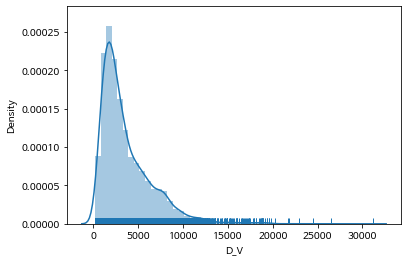

In [30]:
sns.distplot(use_history['D_V'], kde=True, rug=True)

---
### 1-4 재휴폐업까지 걸린 기간이 6개월이 넘는 기업의 수
---

    애당초 재 휴폐업을 하는 경우도 약 400여개로 적으며
    6개월 이상의 기간이 걸리는 경우, 개수는 238개로 더 적어진다.

In [31]:
# 사업자번호의 중복값의 시작값은 True
data_a = data_history['BIZ_NO'].duplicated()

# 사업자번호 전체 인덱스 값 생성
data_b = list(range(len(data_a)))

for i in range(len(data_a)):
  if data_a[i] == True: # True 라는 것은 사업자번호가 중복되는 값의 시작점이며 다음 True가 나올때 까지 중복된 값임
    data_b.remove(i)
data_b.append(11667)
print(data_b)

[0, 2, 6, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 38, 40, 42, 44, 46, 48, 50, 52, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 85, 87, 89, 91, 93, 95, 97, 101, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 123, 127, 129, 133, 135, 137, 139, 141, 143, 145, 147, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 167, 169, 171, 173, 175, 177, 179, 181, 185, 187, 191, 193, 195, 201, 203, 205, 207, 209, 211, 213, 215, 217, 221, 223, 225, 227, 229, 231, 233, 235, 249, 251, 253, 257, 259, 261, 263, 265, 271, 273, 276, 279, 281, 283, 287, 291, 295, 297, 299, 300, 302, 303, 305, 307, 309, 311, 313, 315, 317, 319, 321, 323, 325, 327, 329, 330, 332, 333, 335, 337, 339, 341, 343, 345, 347, 349, 351, 353, 357, 365, 367, 369, 371, 375, 377, 378, 382, 384, 386, 388, 390, 392, 394, 396, 400, 402, 404, 406, 408, 410, 412, 414, 416, 418, 420, 424, 426, 428, 430, 432, 434, 435, 437, 439, 441, 443, 445, 447, 449, 451, 453, 455, 457, 459, 462, 464, 466, 468, 470, 472, 474, 47

In [32]:
############ 휴폐업을 1번이라도 진행한 값을 뺴는 코드 ############
aa = data_history.copy()

for i in range(len(data_b)):
  try:
    num = data_b[i+1]-1
    aa = aa.drop(num, axis = 0)
  except:
    pass 

In [ ]:
again_6m = aa[(aa['CLSBZ_GB'] < 5) & (aa['CLOSE_DATE'] >= 180)]
again_6m

In [34]:
print('하나의 기업이 재 휴폐업을 하기까지 걸린 기간이 6개월 이상인 개수 :',len(again_6m))
print('위 개수 중 동일 사업자를 제거한 후 개수 :',len(set(again_6m['BIZ_NO'])))
## 즉 최대 10개의 기업은 중복이 여러번 휴폐업을 진행했다

하나의 기업이 재 휴폐업을 하기까지 걸린 기간이 6개월 이상인 개수 : 238
위 개수 중 동일 사업자를 제거한 후 개수 : 228


---
### 1-5 데스밸리 구간 구분
---

In [35]:
print('전체 사업자등록번호 수 :',len(use_history))

전체 사업자등록번호 수 : 7467


In [36]:
labels = ['1년 사이','1~3년 사이','3~5년 사이','5~7년 사이','7~10년 사이','10~15년 사이','15~20년 사이','20년 이상']
ranges = [0,365, 1095,1825, 2555, 3650, 5475, 7300, max(use_history['D_V'])]

D_V_bins = pd.cut(use_history['D_V'].tolist(),ranges, labels = labels)
D_V_bins.describe()

,counts,freqs
categories,,
1년 사이,67,0.008973
1~3년 사이,767,0.102719
3~5년 사이,1379,0.184679
5~7년 사이,1254,0.167939
7~10년 사이,1262,0.169010
10~15년 사이,1147,0.153609
15~20년 사이,718,0.096156
20년 이상,873,0.116914


In [37]:
# 구분     1년   2년   3년    4년   5년    7년   10년  15년   20년
labels = ['1년 사이', '1~2년 사이','2~3년 사이','3~4년 사이','4~5년 사이','5~7년 사이','7~10년 사이','10~15년 사이','15~20년 사이','20년 이상']
ranges = [0, 365, 730, 1095, 1460, 1825, 2555, 3650, 5475, 7300, max(use_history['D_V'])]


D_V_bins = pd.cut(use_history['D_V'].tolist(),ranges, labels = labels)
D_V_bins.describe()

,counts,freqs
categories,,
1년 사이,67,0.008973
1~2년 사이,261,0.034954
2~3년 사이,506,0.067765
3~4년 사이,683,0.091469
4~5년 사이,696,0.093210
5~7년 사이,1254,0.167939
7~10년 사이,1262,0.169010
10~15년 사이,1147,0.153609
15~20년 사이,718,0.096156


---
### 1-6. 전체 기업수 대비 분포 확인
---

In [38]:
new_df = use_history[['BIZ_NO','D_V']]

- 액티브 기업개요_외감 데이터 존속기간 생성

In [39]:
# 현 float64 형태를 str로 변경 해줘야 됨
# 빈 값들을 살려주기 위해 -1로 변환 후 다시 공백 변환
active_ex['설립일자'] = active_ex['설립일자'].fillna(-1).astype('int64').replace({-1:None})

# 1900년 보다 작게 설정된 값들은 오기입 으로 간주하고 모두 Null(-1)값으로 변환
for i in range(len(active_ex)):
  try:
    if active_ex['설립일자'][i] < 19000000 :
      active_ex['설립일자'][i] = -1
  except:
    pass

active_ex['설립일자'] = active_ex['설립일자'].fillna(-1).astype('str').replace({'-1':None})

In [40]:
# 데이터 중 20000700과 같이 일자가 00으로 체크된 데이터 01로 임의로 변경
for i in range(len(active_ex)):
  try:
    if active_ex['설립일자'][i][-2 : ] == '00':
      active_ex['설립일자'][i] = active_ex['설립일자'][i][:-2] + '01'
  except:
    pass
active_ex['설립일자'] = pd.to_datetime(active_ex['설립일자'],format='%Y-%m-%d')

In [41]:
active_ex['존속기간'] = None
today = datetime.now()
# now_day = f'{today.year}{today.month}{today.day}'
now_day = '20221027'
date_0 = datetime.strptime(now_day, '%Y%m%d')

for i in range(len(active_ex)):
  active_ex['존속기간'][i] = (date_0 - active_ex['설립일자'][i]).days

- 휴폐업 기업개요 데이터 존속기간 생성

In [42]:
# 현 float64 형태를 str로 변경 해줘야 됨
# 빈 값들을 살려주기 위해 -1로 변환 후 다시 공백 변환
close_normal['설립일자'] = close_normal['설립일자'].fillna(-1).astype('int64').replace({-1:None})

# 1900년 보다 작게 설정된 값들은 오기입 으로 간주하고 모두 Null(-1)값으로 변환
for i in range(len(close_normal)):
  try:
    if close_normal['설립일자'][i] < 19000000 :
      close_normal['설립일자'][i] = -1
  except:
    pass

close_normal['설립일자'] = close_normal['설립일자'].fillna(-1).astype('str').replace({'-1':None})

In [43]:
# 데에티 중 20000700과 같이 일자가 00으로 체크된 데이터 01로 임의로 변경
for i in range(len(close_normal)):
  try:
    if close_normal['설립일자'][i][-2 : ] == '00':
      close_normal['설립일자'][i] = close_normal['설립일자'][i][:-2] + '01'
  except:
    pass
close_normal['설립일자'] = pd.to_datetime(close_normal['설립일자'],format='%Y-%m-%d')

In [44]:
close_normal['존속기간'] = None
today = datetime.now()
# now_day = f'{today.year}{today.month}{today.day}'
now_day = '20221027'
date_0 = datetime.strptime(now_day, '%Y%m%d')

for i in range(len(close_normal)):
  close_normal['존속기간'][i] = (date_0 - close_normal['설립일자'][i]).days

- 액티브, 휴폐업 데이터 중 데스밸리와 중복인 사업자번호 제거

In [45]:
test_active = active_ex[['사업자등록번호','존속기간']]

for i in range(len(test_active)):
  if test_active['사업자등록번호'][i] in new_df['BIZ_NO'].tolist():
    test_active = test_active.drop(i, axis = 0)

In [ ]:
test_close = close_normal[['사업자등록번호','존속기간']]

for i in range(len(test_close)):
  if test_close['사업자등록번호'][i] in new_df['BIZ_NO'].tolist():
    test_close = test_close.drop(i, axis = 0)

In [47]:
print('액티브 데이터 수:',len(active_ex))
print('중복 제거 후 데이터 수:',len(test_active))
print('중복으로 제거된 데이터 수:',len(active_ex)-len(test_active))

액티브 데이터 수: 28982
중복 제거 후 데이터 수: 28785
중복으로 제거된 데이터 수: 197


In [48]:
print('액티브 데이터 수:',len(close_normal))
print('중복 제거 후 데이터 수:',len(test_close))
print('중복으로 제거된 데이터 수:',len(close_normal)-len(test_close))

액티브 데이터 수: 6739
중복 제거 후 데이터 수: 568
중복으로 제거된 데이터 수: 6171


In [49]:
test_active = test_active.dropna()
test_close = test_close.dropna()

test_df = pd.concat([test_active,test_close], ignore_index = True)
test_df.columns = ['BIZ_NO','D_V']

In [50]:
# 구분     1년   2년   3년    4년   5년    7년   10년  15년   20년
labels = ['1년 사이', '1~2년 사이','2~3년 사이','3~4년 사이','4~5년 사이','5~7년 사이','7~10년 사이','10~15년 사이','15~20년 사이','20년 이상']
ranges = [0, 365, 730, 1095, 1460, 1825, 2555, 3650, 5475, 7300, max(test_df['D_V'])]


test_D_V_bins = pd.cut(test_df['D_V'].tolist(),ranges, labels = labels)
test_D_V_bins.describe()

,counts,freqs
categories,,
1년 사이,8,0.000289
1~2년 사이,128,0.004619
2~3년 사이,761,0.027460
3~4년 사이,859,0.030996
4~5년 사이,916,0.033053
5~7년 사이,1987,0.071699
7~10년 사이,3151,0.113701
10~15년 사이,4713,0.170065
15~20년 사이,4228,0.152564


In [59]:
d_v = {'1년 사이' : 67 / (67 + 8), "1~2년 사이" : 261 / (128 + 261), "2~3년 사이" : 506 / (761 + 506),
               "3~4년 사이" : 683 / (859 + 683), "4~5년 사이" : 696 / (916 + 696), "5~7년 사이" : 1254 / (1987 + 1254),
               "7~10년 사이" : 1262 / (3151 + 1262), "10~15년 사이" : 1147 / (4713 + 1147), "15~20년 사이" : 718 / (4228 + 718), "20년 이상" : 873 / (10962 + 873)}

death_valley = pd.DataFrame(d_v.items(), columns = ['기간','휴폐업률'])
death_valley

,기간,휴폐업률
0,1년 사이,0.893333
1,1~2년 사이,0.670951
2,2~3년 사이,0.399369
3,3~4년 사이,0.442931
4,4~5년 사이,0.431762
5,5~7년 사이,0.386918
6,7~10년 사이,0.285973
7,10~15년 사이,0.195734
8,15~20년 사이,0.145168
9,20년 이상,0.073764


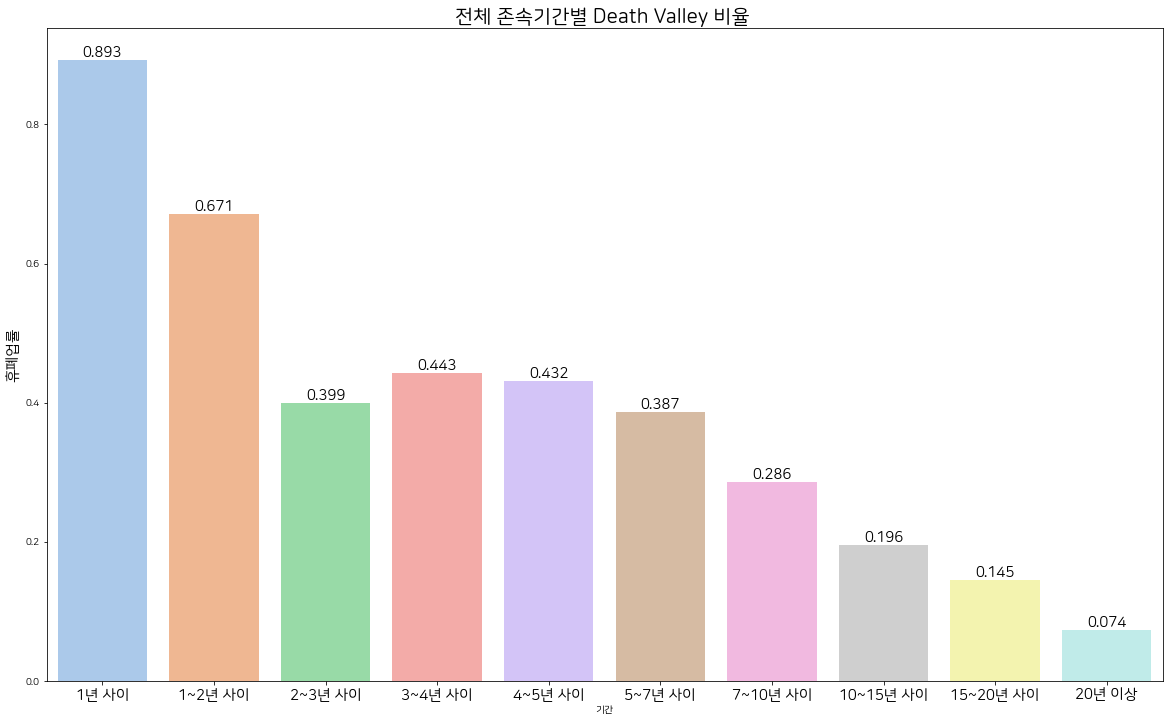

In [121]:
plt.figure(figsize=(20,12))
fig = sns.barplot(x = '기간',y = '휴폐업률', data = death_valley)
plt.title('전체 존속기간별 Death Valley 비율 ', fontsize = 20)
plt.xticks(fontsize = 15)
plt.ylabel('휴폐업률',fontsize = 15)
# 숫자 넣는 부분
for rect in fig.patches:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.3f' % height, ha='center', va='bottom', size = 15)
    
sns.set_palette('pastel')
plt.show()

---
### 1-7 기업들이 휴폐업을 반복하는 횟수가 얼마인가?
----

    휴폐업 빈도가 0인 개수 : 0
    휴폐업 빈도가 1인 개수 : 10202
    휴폐업 빈도가 2인 개수 : 968
    휴폐업 빈도가 3인 개수 : 257
    휴폐업 빈도가 4인 개수 : 122
    휴폐업 빈도가 5인 개수 : 30
    휴폐업 빈도가 6인 개수 : 12
    휴폐업 빈도가 7인 개수 : 14
    휴폐업 빈도가 8인 개수 : 0
    휴폐업 빈도가 9인 개수 : 18

In [55]:
aa = data_history.copy()
biz_number = aa['BIZ_NO'].tolist()

frequency = []
for i in range(len(aa)):
  bb = aa[aa['BIZ_NO'] == biz_number[i]]
  bb = bb.reset_index(drop = True)
  count = 0
  for j in range(len(bb)):
    if (bb['CLSBZ_GB'][j] == 2) | (bb['CLSBZ_GB'][j] == 3):
      count += 1
  if count != 0:
    frequency.append(count)
# frequency

In [56]:
print('휴폐업 빈도가 가장 많은 수 :',max(frequency))

휴폐업 빈도가 가장 많은 수 : 9


In [57]:
for i in range(max(frequency)+1):
  print(f'휴폐업 빈도가 {i}번인 기업 수 :',frequency.count(i))

휴폐업 빈도가 0번인 기업 수 : 0
휴폐업 빈도가 1번인 기업 수 : 10202
휴폐업 빈도가 2번인 기업 수 : 968
휴폐업 빈도가 3번인 기업 수 : 257
휴폐업 빈도가 4번인 기업 수 : 122
휴폐업 빈도가 5번인 기업 수 : 30
휴폐업 빈도가 6번인 기업 수 : 12
휴폐업 빈도가 7번인 기업 수 : 14
휴폐업 빈도가 8번인 기업 수 : 0
휴폐업 빈도가 9번인 기업 수 : 18
